In [16]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.fft as npf
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools as im

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
%matplotlib notebook

# 4

In [18]:
x=plt.imread('assets/starfish.png')

In [19]:
y = plt.imread('assets/topgun.png')

<IPython.core.display.Javascript object>


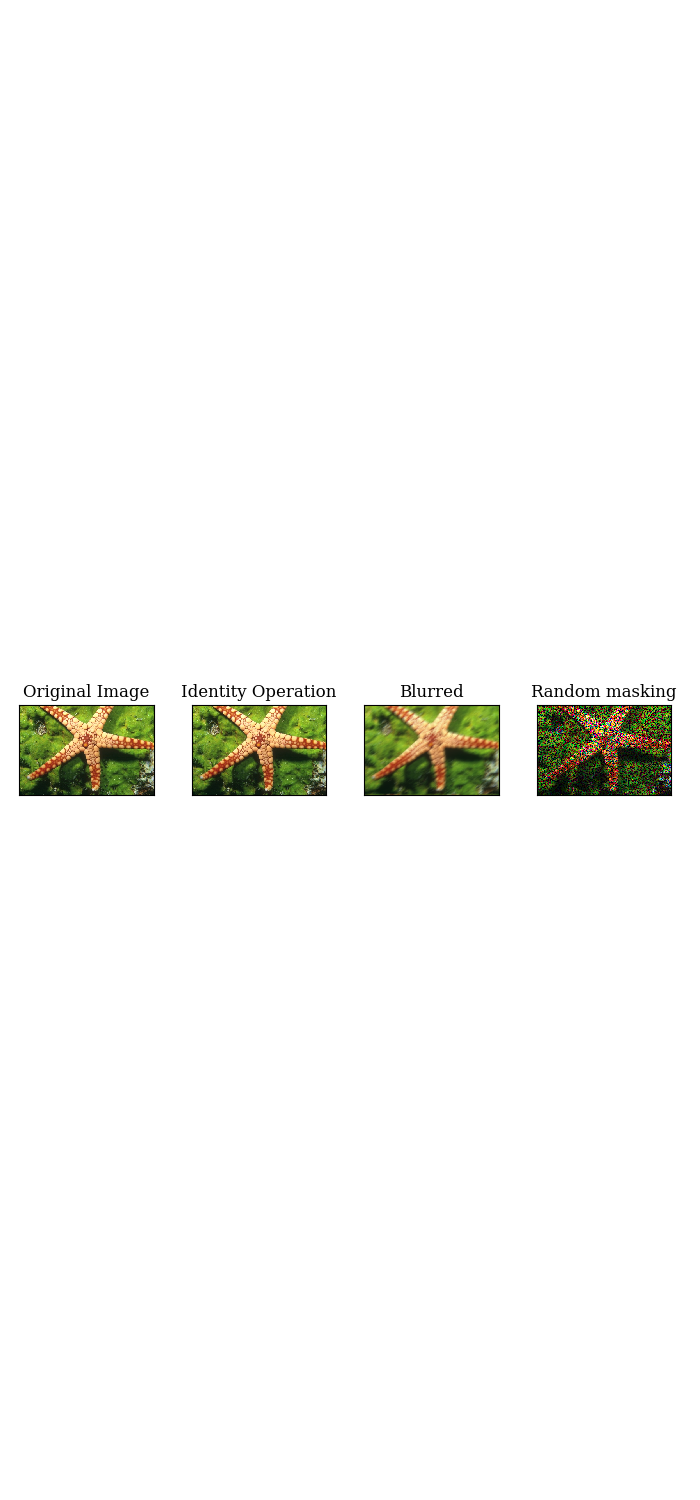

In [22]:
random_masking = im.RandomMasking(x.shape,0.4)
identity = im.Identity(x.shape)
motion_blur = im.Convolution(x.shape,im.kernel("motion"))

fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(7,15))
axes[0].imshow(x)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Original Image")

axes[1].imshow(identity(x))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("Identity Operation")

axes[2].imshow(motion_blur(x))
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title("Blurred")

axes[3].imshow(random_masking(x))
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[3].set_title("Random masking")

# 5

In [23]:
def matrix_product(x,y):
    '''
    computes matrix dot product
    '''
    return np.sum(x*y)

## Random Masking

In [24]:
print("Comparison of matrix products <Hx,y> and <x,H*y> returns {}".format(np.allclose(matrix_product(random_masking(x),y),matrix_product(x,random_masking.adjoint(y)))))

Comparison of matrix products <Hx,y> and <x,H*y> returns True


## Identity

In [25]:
print("Comparison of matrix products <Hx,y> and <x,H*y> returns {}".format(np.allclose(matrix_product(identity(x),y),matrix_product(x,identity.adjoint(y)))))

Comparison of matrix products <Hx,y> and <x,H*y> returns True


## Convolution

In [26]:
print("Comparison of matrix products <Hx,y> and <x,H*y> returns {}".format(np.allclose(matrix_product(motion_blur(x),y),matrix_product(x,motion_blur.adjoint(y)))))

Comparison of matrix products <Hx,y> and <x,H*y> returns True


# 6

In [27]:
def inv_gram_res(obj,x,tau):
    '''
    Computes inverse of gram resolvent matrix
    Args:
        obj: operation
        x: input image
        tau: constant of regularization
    Returns:
        inverse of gram resolvent
    '''
    return x + (tau*obj.adjoint(obj(x)))

## Identity

In [28]:
confirm = identity.gram_resolvent(inv_gram_res(identity,x,2),2)
print("Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is {0}".format(np.allclose(confirm,x)))

Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is True


## Random Masking

In [29]:
confirm = random_masking.gram_resolvent(inv_gram_res(random_masking,x,2),2)
print("Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is {}".format(np.allclose(confirm,x)))

Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is True


## Motion Blur

In [30]:
confirm = motion_blur.gram_resolvent(inv_gram_res(motion_blur,x,2),2)
print("Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is {}".format(np.allclose(confirm,x,atol=1e-2)))

Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is True


# 8 

<IPython.core.display.Javascript object>


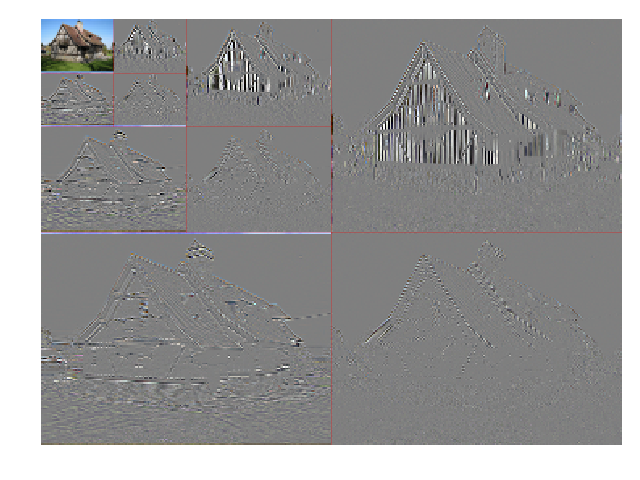

In [31]:
x0 = plt.imread("assets/normandy.png")
J = 3
h,g = im.wavelet('db2')
y0 = im.dwt(im.dwt_crop(x0,J),J,h,g)
im.showdwt(y0,J=3)

# 9

<IPython.core.display.Javascript object>


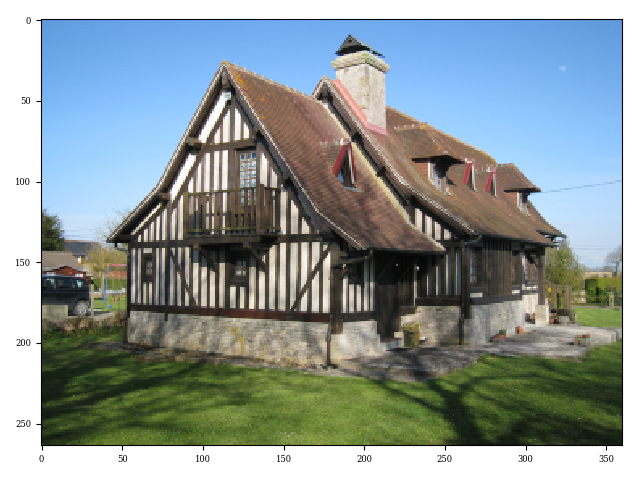

In [32]:
x = im.idwt(y0,J,h,g)
plt.imshow(x)

# 10

In [33]:
confirm = im.dwt(im.idwt(y0,J,h,g),J,h,g)
print("Confirm if dwt is left inverse idwt of {}".format(np.allclose(confirm,y0)))

Confirm if dwt is left inverse idwt of True


In [34]:
confirm = im.idwt(im.dwt(im.dwt_crop(x0,J),J,h,g),J,h,g)
print("Confirm if idwt is left inverse dwt of {}".format(np.allclose(confirm,im.dwt_crop(x0,J))))

Confirm if idwt is left inverse dwt of True


In [35]:
x=im.dwt_crop(plt.imread('assets/starfish.png'),J)
y =im.dwt_crop(plt.imread('assets/topgun.png'),J)
print("Confirm that idwt in adjoint of dwt {}".format(np.allclose(matrix_product(im.dwt(x,J,h,g),y),matrix_product(x,im.idwt(y,J,h,g)))))

Confirm that idwt in adjoint of dwt True


# 12

In [36]:
def softthresh(z,t):
    '''
    Implements soft thresholding of matrix z with threshold t
    Args:
        z: array
        t: threshold
    Returns:
        threshold: thresholded version of z
    '''
    z = np.maximum(z-t,np.zeros_like(z)) + np.minimum(z+t,np.zeros_like(z))
    return z
def softthresh_denoise(y, sig, W, alpha=10/255):
    tau = np.sqrt(2)*np.square(sig)/(alpha*W.power())
    return W.invert(softthresh(W(y),tau))

In [37]:
J=3
clean = im.dwt_crop(plt.imread("assets/dragonfly.png"),J)
W = im.DWT(clean.shape,J)
sig = 20 / 255
noisy = clean + sig * np.random.randn(*clean.shape)
psnr = [im.psnr(clean,softthresh_denoise(noisy, sig, W, alpha=i/255)) for i in range(5,16)]

<IPython.core.display.Javascript object>


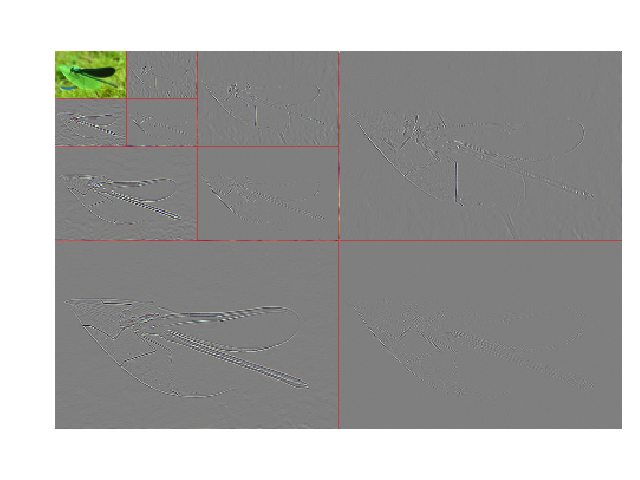

In [38]:
plt.plot([i for i in range(5,16)],psnr)
plt.xlabel("Values of alpha")
plt.ylabel("PSNR")

# 15

In [393]:
def interleave0(x,j):
    '''
    upsample the filters
    h and g by injecting 2^(j − 1) zeros between each entries.
    '''
    x1=np.zeros(((np.shape(x)[0]-1)*pow(2,j)+1,1))
    for i in range(len(x)):
        x1[pow(2,j)*i]=x[i]
    return x1

In [394]:
def udwt(x, J, h, g):
    if J == 0:
        return x[:, :, None]
    tmph = np.rot90(im.convolve(np.rot90(x,k=3), h),k=1) / 2
    tmpg = np.rot90(im.convolve(np.rot90(x,k=3), g),k=1) / 2     
    z = np.stack((im.convolve(tmpg, h),im.convolve(tmph, g),im.convolve(tmph, h)), axis=2)
    coarse = im.convolve(tmpg, g)
    h2 = interleave0(h,J)
    g2 = interleave0(g,J)
    z = np.concatenate((udwt(coarse, J - 1, h2, g2), z),axis=2)
    return z

## 16

<IPython.core.display.Javascript object>


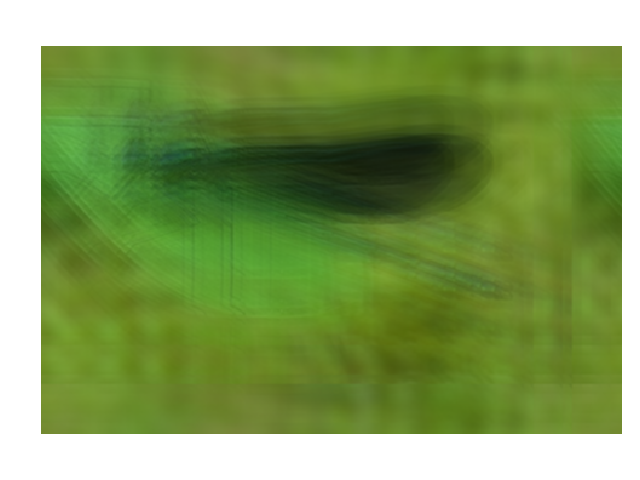

In [434]:
x0 = plt.imread("assets/dragonfly.png")
J = 3
h,g = im.wavelet('db2')
y0=udwt(im.dwt_crop(x0,J),J,h,g)
im.show(y0[:,:,0,:])
plt.show()

<IPython.core.display.Javascript object>


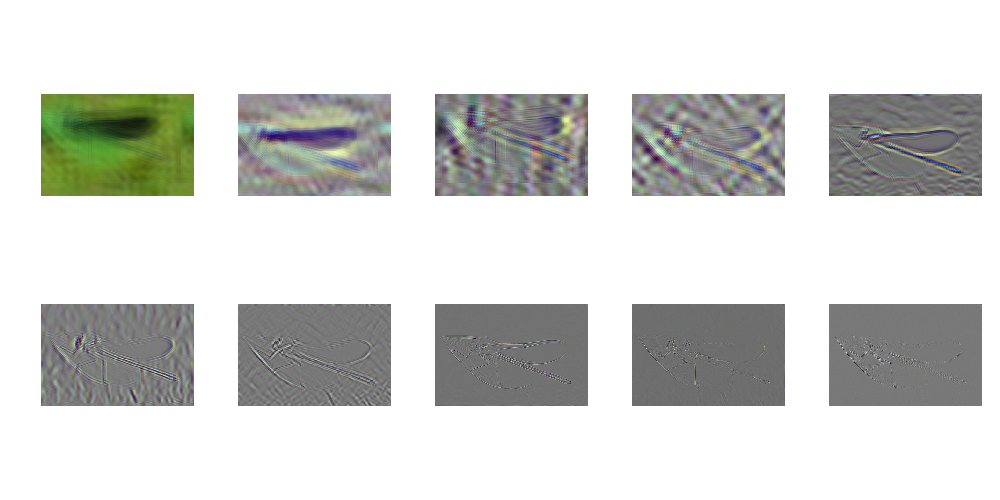

In [443]:
fig,axes= plt.subplots(nrows=2,ncols=5,figsize=(10,5))
im.show(y0[:,:,0,:],ax=axes[0][0])
im.showdwt(y0[:,:,1,:],J=0,ax=axes[0][1])
im.showdwt(y0[:,:,2,:],J=0,ax=axes[0][2])
im.showdwt(y0[:,:,3,:],J=0,ax=axes[0][3])
im.showdwt(y0[:,:,4,:],J=0,ax=axes[0][4])
im.showdwt(y0[:,:,5,:],J=0,ax=axes[1][0])
im.showdwt(y0[:,:,6,:],J=0,ax=axes[1][1])
im.showdwt(y0[:,:,7,:],J=0,ax=axes[1][2])
im.showdwt(y0[:,:,8,:],J=0,ax=axes[1][3])
im.showdwt(y0[:,:,9,:],J=0,ax=axes[1][4])

In [431]:
np.shape(y0)

(320, 480, 10, 3)

## Q17

In [409]:
def iudwt(z, J, h, g):
    if J == 0:
        return z[:, :, 0]
    h2 = interleave0(h,J)
    g2 = interleave0(g,J)
    coarse = iudwt(z[:, :, :-3], J - 1, h2, g2)
    tmpg = im.convolve(coarse, g[::-1]) + im.convolve(z[:, :, -3], h[::-1])
    tmph = im.convolve(z[:, :, -2], g[::-1]) + im.convolve(z[:, :, -1], h[::-1])
    x = (np.rot90(im.convolve(np.rot90(tmpg,k=3), g[::-1]),k=1) + np.rot90(im.convolve(np.rot90(tmph,k=3), h[::-1]),k=1)) / 2
    return x


## Q18

In [421]:
print("Checking udwt and iudwt are inverse of each other",np.allclose(iudwt(udwt(im.dwt_crop(x0,J),J,h,g) ,J, h, g),im.dwt_crop(x0,J)))


Checking udwt and iudwt are inverse of each other True


In [418]:
y=udwt(im.dwt_crop(x0,J),J,h,g)

In [426]:
np.allclose(y,udwt(iudwt(y,J, h, g),J, h, g))

False

## Q19

In [428]:
def udwt_create_fb(n1, n2, J, h, g, ndim=3):
    if J == 0:
        return np.ones((n1, n2, 1, *[1] * (ndim - 2)))
    h2 = interleave0(h,J)
    g2 = interleave0(g,J)
    fbrec = udwt_create_fb(n1, n2, J - 1, h2, g2, ndim=ndim)
    gf1 = nf.fft(fftpad(g, n1), axis=0)
    hf1 = nf.fft(fftpad(h, n1), axis=0)
    gf2 = nf.fft(fftpad(g, n2), axis=0)
    hf2 = nf.fft(fftpad(h, n2), axis=0)
    fb = np.zeros((n1, n2, 4), dtype=np.complex128)
    fb[:, :, 0] = np.outer(gf1, gf2) / 2
    fb[:, :, 1] = np.outer(gf1, hf2) / 2
    fb[:, :, 2] = np.outer(hf1, gf2) / 2
    fb[:, :, 3] = np.outer(hf1, hf2) / 2
    fb = fb.reshape(n1, n2, 4, *[1] * (ndim - 2))
    fb = np.concatenate((fb[:, :, 0:1] * fbrec, fb[:, :, -3:]),axis=2)
    return fb

In [429]:
def fb_apply(x, fb):
    x = nf.fft2(x, axes=(0, 1))
    z = fb * x[:, :, np.newaxis]
    z = np.real(nf.ifft2(z, axes=(0, 1)))
    return z

In [430]:
def fb_adjoint(z, fb):
    z = nf.fft2(z, axes=(0, 1))
    x = (np.conj(fb) * z).sum(axis=2)
    x = np.real(nf.ifft2(x, axes=(0, 1)))
    return x